# PC Session 1

# **Machine Learning for Prediction**

**Authors:**
[Anthony Strittmatter](http://www.anthonystrittmatter.com),
[Helge Liebert](https://hliebert.github.io/), and
Johnathan Chassot

You want to buy an used car at the online auction platform *MyLemons*. You are worried that many used cars on this platform are overpriced. Therefore, you want to do some market research before you buy an used car. For this purpose, you web-scrape the used car offers on the *MyLemons* platform. You obtain the following variables:

|Variable name| Description|
|:----|:----|
|**Outcome variables** ||
|*first_price*| First asking price in 1,000 CHF |
|*final_price*| Transaction price in 1,000 CHF|
|*overprice*| Dummy indicating *first_price > final_price* |
|**Baseline covariates**| |
|*bmw_320, opel_astra, mercedes_c, vw_golf, vw_passat*| Dummies for the car make and model|
|*mileage*| Mileage of the used car (in 1,000 km)|
|*age_car_years*| Age of the used car (in years)|
|*diesel*| Dummy for diesel engines |
|*private_seller*| Dummy for private seller (as opposed to professional used car sellers) |
|*other_car_owner*| Number of previous caar owners |
|*guarantee*| Dummy indicating that the seller offers a guarantee for the used car|
|*maintenance_cert*| Dummy indicating that the seller has a complete maintenace certificate for the used car|
|*inspection*| Categorial variable for the duration until next general inspection (3 categories: new, 1-2 years, > 2 years) |
|*pm_green*| Dummy indicating that the used car has low particular matter emissions|
|*co2_em*| CO2 emssion (in liter per 100km)|
|*euro_norm*| EURO emission norm under which the car is registered |


Furthermore, you generate some transformations of your covariates that you want to use for later analysis. The transformed covariates are:

|Variable name| Description|
|:----|:----|
|**Additional covariates** ||
|*mileage2, mileage3, mileage4, age_car_years2, age_car_years3, age_car_years4*| Squared, cubic, and quadratic *mileage* and *age_car_years* |
|*mile_20, mile_30, mile_40, mile_50, mile_100, mile_150*| Dummies indicating that the used car has a mileage above 20,000km, 30,000km, 40,000km, 50,000km, 100,000km, or 150,000km |
|*age_3, age_6*| Dummies indicating that the used car is above 3 or 6 years old |
|*dur_next_ins_1_2*| Dummy indicating that the duration until the next general inspection is between 1 and 2 years |
|*new_inspection*| Dummy indicating that the used car has a new general inspection |


You store the prepared data in the file *used_cars.csv*. Now you start you analysis. 


## Load Packages

In the first place, you install and load the R-packages you want to use.

In [37]:
# List of required packages
pkgs <- c('fBasics', 'corrplot', 'psych', 'glmnet', 'glmnetUtils', 'rpart',
          'rpart.plot', 'treeClust', 'randomForest', 'rlang', 'readr', 'devtools',
          'tidyverse', 'reshape2', 'caret')
# Load packages (install if needed)
for(pkg in pkgs){
    if(!(pkg %in% rownames(installed.packages()))){
        install.packages(pkg, repos="http://stat.ethz.ch/CRAN")
    }
    library(pkg, character.only = TRUE)
}
print('All packages successfully installed and loaded.')

[1] "All packages successfully installed and loaded."


## Load Data Frame

Now you load the data frame and define different covariate categories. You distinguish between binary and continuous/discrete covariates. Furthermore, you decrease the sample size to 10,000 in order to decrease the computation time while you are testing your code. You plan to use the entire sample of 78,645 used cars after you are finised with programming.

In [38]:
set.seed(100231) # set starting value for random number generator

# Load data frame
data_raw <- read.csv("used_cars.csv",header=TRUE, sep=",")

# Outcome Variables
outcomes <- c("first_price", "final_price", "overprice")

# Covariates/Features
baseline_covariates_bin <- c("bmw_320", "opel_astra", "mercedes_c", "vw_golf", "vw_passat", 
                          "diesel",   "private_seller", "guarantee", "maintenance_cert",  "pm_green") # binary
baseline_covariates_cont <- c("mileage", "age_car_years", "other_car_owner", "inspection",
                              "co2_em", "euro_norm") # continuous/discrete
baseline_covariates <- c(baseline_covariates_cont,baseline_covariates_bin)
lasso_covariates_bin <- c("mile_20", "mile_30", "mile_40", "mile_50", "mile_100", "mile_150", 
                       "age_3", "age_6", "dur_next_ins_1_2", "new_inspection") # binary 
lasso_covariates_cont <- c("mileage2", "mileage3", "mileage4", "age_car_years2", "age_car_years3",
                           "age_car_years4") # continuous/discrete

lasso_covariates <- c(lasso_covariates_cont, lasso_covariates_bin)  
all_covariates <- c(baseline_covariates, lasso_covariates)
all_variables <- c(outcomes, all_covariates)

# Selection of Subsample size, max. 78,645 observations
# Select smaller subsample to decrease computation time
n_obs <- 10000
df <- data_raw %>%
  dplyr::sample_n(n_obs) %>%
  dplyr::select(all_variables)

print('Data frame successfully loaded and sample selected.')

[1] "Data frame successfully loaded and sample selected."


## Descriptive Statistics

### Means and Standard Deviations

Now you have a look at the descriptive statistics to check for data errors and missing values.

In [40]:
# Table of descriptive statistics
desc <- fBasics::basicStats(df) %>% t() %>% as.data.frame() %>% 
  select(Mean, Stdev, Minimum, Maximum, nobs)
print(round(desc, digits=1))

# Print as tex-file
#kable(desc, "latex", booktabs = T)

                        Mean       Stdev Kurtosis Minimum      Maximum  nobs
first_price             15.6         7.4      6.6       1        100.5 10000
final_price             15.2         7.1      3.3       1         98.7 10000
overprice                0.6         0.5     -1.8       0          1.0 10000
mileage                100.4        49.8     -0.9      10        200.0 10000
age_car_years            4.6         2.6      1.6       1         19.4 10000
other_car_owner          1.1         0.7      0.6       0          6.0 10000
inspection               0.9         0.7     -1.1       0          2.0 10000
co2_em                 138.8        24.9      1.7       1        249.0 10000
euro_norm                4.8         0.6      3.6       1          6.0 10000
bmw_320                  0.2         0.4     -0.5       0          1.0 10000
opel_astra               0.1         0.3      3.6       0          1.0 10000
mercedes_c               0.1         0.3      2.3       0          1.0 10000

### Correlation Matrix

You plot the correlation matrix. The correlation structure between the covariates is important for the later interpretation of the results.

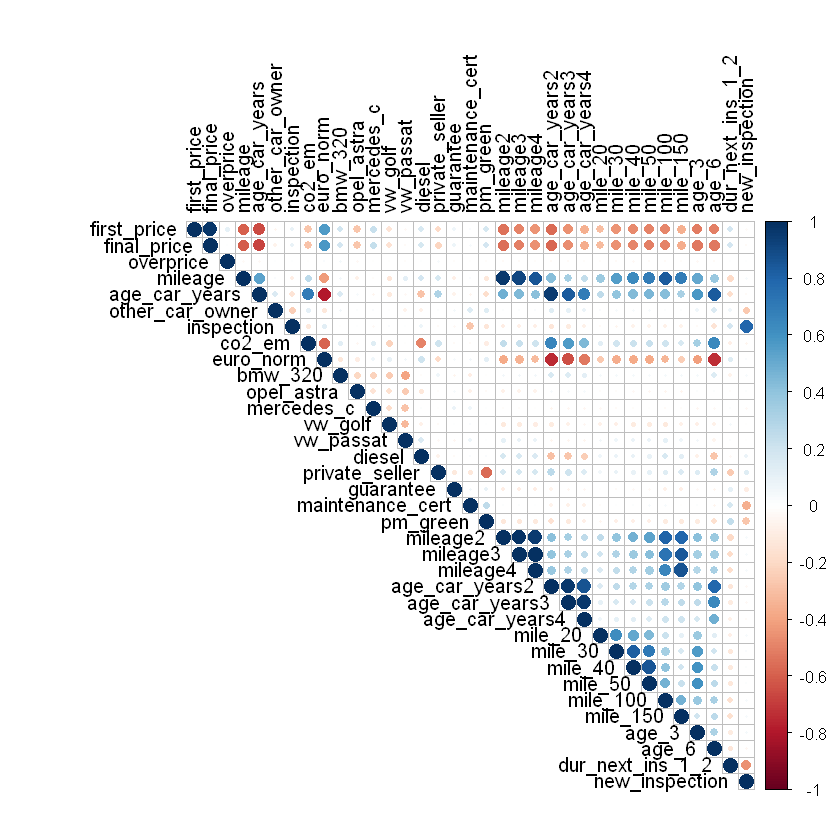

In [30]:
# Plot correlation matrix
corr = cor(df)
corrplot(corr, type = "upper", tl.col = "black")

# Save correlation matrix as png-file
#png(height=1200, width=1200, file="correlation.png")
    #corrplot(corr, type = "upper", tl.col = "black")
#dev.off()


## Extract Data

You extract the different variable categories from your data frame and drop observations with missing values.

In [32]:
########################  Extract dataset  ########################

# Extracting continuous variables
baseline_covariates_cont <- df %>%
  dplyr::select(baseline_covariates_cont) 

lasso_covariates_cont <- df %>%
  dplyr::select(lasso_covariates_cont) 

# Extracting indicator variables
baseline_covariates_bin <- df %>%
  dplyr::select(baseline_covariates_bin)

lasso_covariates_bin <- df %>%
  dplyr::select(lasso_covariates_bin)

# Extracting outcome 
outcomes <- df %>% dplyr::select(outcomes)

# Setting up the data, renaming columns and discarding rows with NA (if any)
df <- bind_cols(outcomes, baseline_covariates_cont, baseline_covariates_bin, lasso_covariates_cont, lasso_covariates_bin) %>%
  na.omit()

print('Data successfully extracted.')

[1] "Data successfully extracted."


## Take Hold-Out-Sample and Scale Data

You want to compare the relative prediction power of different estimation procedures based on the out-of-sample MSE and $R^2$. For this purpose, you create a training/estimation- and hold-out-sample. You will use the training/estimation-sample to train the machine learning procedures and estimate the final used car prices. Then you will extrapolate the results to the retared hold-out-sample.


Furthermore, you standardise the continuous covariates by the means and standard deviations in the training/estimation-sample. Some machine learning algorithms are sensitive to rescaling. Even though most machine learning procedures standardise the covariates automatically, this is a cautionary transformation for those procedures that have no automatic standardisation implemented.

In [33]:
########################  Take hold-out-sample  ########################

df_part <- modelr::resample_partition(df, c(obs = 0.8, hold_out = 0.2))
df_obs <- as.data.frame(df_part$obs) # Training and estimation sample
df_hold_out <- as.data.frame(df_part$hold_out) # Hold-out-sample

# Outcomes
first_price_obs <- as.matrix(df_obs[,1])
final_price_obs <- as.matrix(df_obs[,2])
overprice_obs <- as.matrix(df_obs[,3])

first_price_hold_out <- as.matrix(df_hold_out[,1])
final_price_hold_out <- as.matrix(df_hold_out[,2])
overprice_hold_out <- as.matrix(df_hold_out[,3])

## Covariates/Features
baseline_covariates_cont_obs <- as.matrix(df_obs[,c(4:9)])
baseline_covariates_bin_obs <- as.matrix(df_obs[,c(10:19)])
baseline_covariates_hold_cont_out <- as.matrix(df_hold_out[,c(4:9)])
baseline_covariates_hold_bin_out <- as.matrix(df_hold_out[,c(10:19)])

# Standardise continuous variables
preProcValues <- preProcess(baseline_covariates_cont_obs, method = c("center", "scale")) # Take means and standard deviations from training sample
ObsTransformed <- predict(preProcValues, baseline_covariates_cont_obs) # Apply the transformation to trainings sample
HoldOutTransformed <- predict(preProcValues, baseline_covariates_hold_cont_out) # Apply the transformation to hold-out-sample (based on means and standard deviations from training sample)
# Note: Outcome variables are not rescaled

baseline_covariates_obs <- as.matrix(cbind(ObsTransformed,baseline_covariates_bin_obs)) 
baseline_covariates_hold_out <- as.matrix(cbind(HoldOutTransformed,baseline_covariates_hold_bin_out)) 
                  
print('The data is now ready for your first analysis!')

[1] "The data is now ready for your first analysis!"


# Tree Estimator

Trees partition the sample into mutually exclusive groups $l_j$, which are called leaves. Let $\pi= \{ l_1, ...,l_{\# (\pi)} \}$ be a specific tree or sample partition, let $l_j \equiv l_j (x,\pi)$ be the respective leaf (for $j=1,…,\#(\pi))$, and let $\#(\pi)$ be the number of leaves in tree $\pi$. The leaf $l_j (x,\pi)$ of tree $\pi$ is a function of the covariate space of $X_{i}$ (for $i = 1,..., N$ used cars) such that $x \in l_j$. 

For an explicit example, consider that $X_{i}$ contains only a binary indicator for used diesel cars. Then, you can choose between two possible trees; either you make no sample split, $\pi'=\{ l_1 \}=\{ \mbox{diesel}, \mbox{gasoline} \}$, or you partition used diesel and gasoline cars into two separate leaves, $\pi'' =\{ l_1,l_2 \}= \{ \{ \mbox{diesel} \}, \{ \mbox{gasoline} \} \}$.  


For a specific sample partition $\pi$, which is called tree, you can predict the final used car price by
\begin{equation*}
\hat{E}[final\_price|(x,\pi)] = \frac{1}{\sum_{i=1}^{N}1\{ X_{i} \in l_j(x,\pi)\}}\sum_{i=1}^{N} 1\{ X_{i} \in l_j(x,\pi)\} \cdot final\_price.
\end{equation*}
Trees select the partition $\pi$ with a greedy algorithm, i.e., by recursively adding leaves to the tree that minimise the MSE. Accordingly, trees aim to partition the sample into leaves with homogeneous outcomes. Because of the a hierarchical partition structure, the first splits contribute more prediction power than the last splits. 

          CP nsplit rel error    xerror       xstd
1 0.33147274      0 1.0000000 1.0002415 0.02666723
2 0.08550624      1 0.6685273 0.6687304 0.01997315
3 0.07344012      2 0.5830210 0.5841441 0.01969729
4 0.02234055      3 0.5095809 0.5040440 0.01708852
5 0.02064299      4 0.4872403 0.4805680 0.01694461
6 0.01443385      5 0.4665974 0.4702051 0.01675832
7 0.01323307      6 0.4521635 0.4551272 0.01669127
8 0.00002000      7 0.4389304 0.4427405 0.01666620
[1] "Optimal number final leaves: 8"
[1] "In-Sample RMSE: 4.696"
[1] "Hold-out-Sample RMSE: 4.699"
[1] "In-Sample R-squared: 0.561"
[1] "Hold-out-Sample R-squared: 0.542"


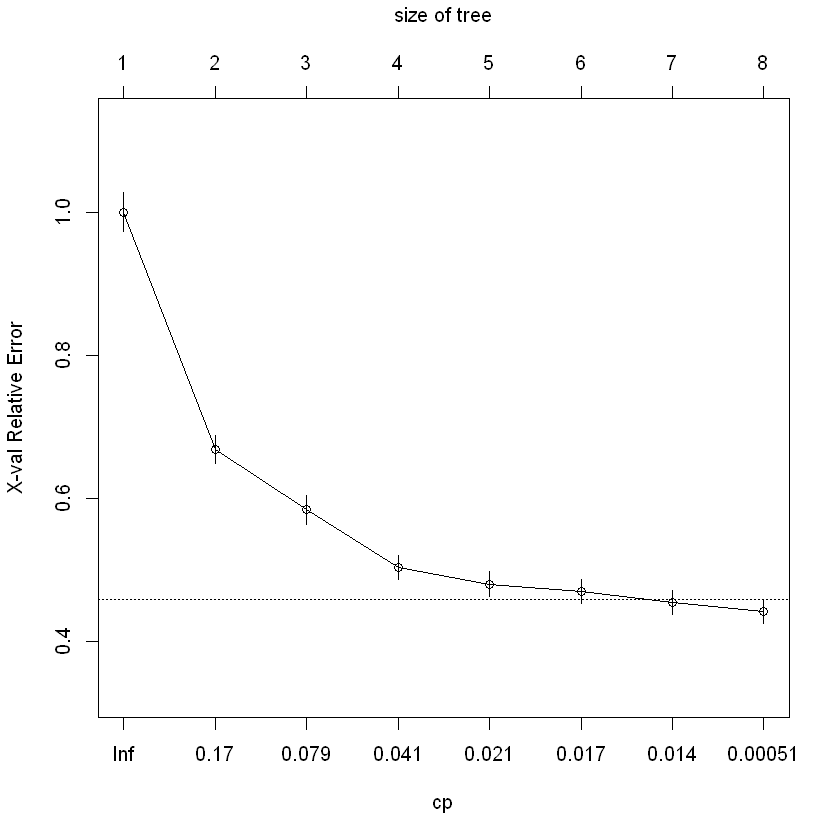

In [41]:
########################  Tree estimator  ########################                         

# Prepare data for tree estimator
tree_data_obs <-  data.frame(final_price_obs, baseline_covariates_obs)
empty <- as.matrix(final_price_hold_out)
empty[1,] <-NA
tree_data_hold_out <- data.frame(rbind(final_price_obs,empty),rbind(baseline_covariates_obs, baseline_covariates_hold_out))

# Setup the formula of the linear regression model
sumx <- paste(baseline_covariates, collapse = " + ")  
linear <- paste("final_price_obs",paste(sumx, sep=" + "), sep=" ~ ")
linear <- as.formula(linear)

# Build the tree
linear.singletree_1 <- rpart(formula = linear, data = tree_data_obs , method = "anova", xval = 10,
                             y = TRUE, control = rpart.control(cp = 0.00002, minbucket=500))

# Plot CV-MSE
plotcp(linear.singletree_1)

# Save CV-MSE as png-file
#png(filename= "cp_tree1.png", units="in", width=5, height=4, pointsize=12, res=72)
#plotcp(linear.singletree_1)
#dev.off()

# Find tree size that minimises CV-MSE
print(linear.singletree_1$cptable)
op.index_1 <- which.min(linear.singletree_1$cptable[, "xerror"])
print(paste0("Optimal number final leaves: ", op.index_1))

# Get cp-value that corresponds to optimal tree size
cp.vals_1 <- linear.singletree_1$cptable[op.index_1, "CP"]

# Prune the tree
treepruned.linearsingle_1 <- prune(linear.singletree_1, cp = cp.vals_1)

# Predict final price in the observed and hold-out-samples
pred_tree_hold_out_1 <- as.matrix(predict(treepruned.linearsingle_1, newdata=tree_data_hold_out))
pred_tree_obs_1 <- pred_tree_hold_out_1[c(1:nrow(tree_data_obs)),]
r <-nrow(final_price_obs)+1
pred_tree_hold_out_1 <- pred_tree_hold_out_1[c(r:nrow(pred_tree_hold_out_1)),]

## Assess performance of tree estimator
# In-sample RMSE
rmse_obs_1 <- round(sqrt(mean((final_price_obs - pred_tree_obs_1)^2)),digits=3)
# Hold-out-sample RMSE
rmse_hold_out_1 <- round(sqrt(mean((final_price_hold_out - pred_tree_hold_out_1)^2)),digits=3)
# In-sample R-squared
r2_obs_1 <- round(1-mean((final_price_obs - pred_tree_obs_1)^2)/mean((final_price_obs - mean(final_price_obs))^2),digits=3)
# Hold-out-sample R-squared
r2_hold_out_1 <- round(1-mean((final_price_hold_out - pred_tree_hold_out_1)^2)/mean((final_price_hold_out - mean(final_price_hold_out))^2),digits=3)

print(paste0("In-Sample RMSE: ", rmse_obs_1))
print(paste0("Hold-out-Sample RMSE: ", rmse_hold_out_1))
print(paste0("In-Sample R-squared: ", r2_obs_1))
print(paste0("Hold-out-Sample R-squared: ", r2_hold_out_1))



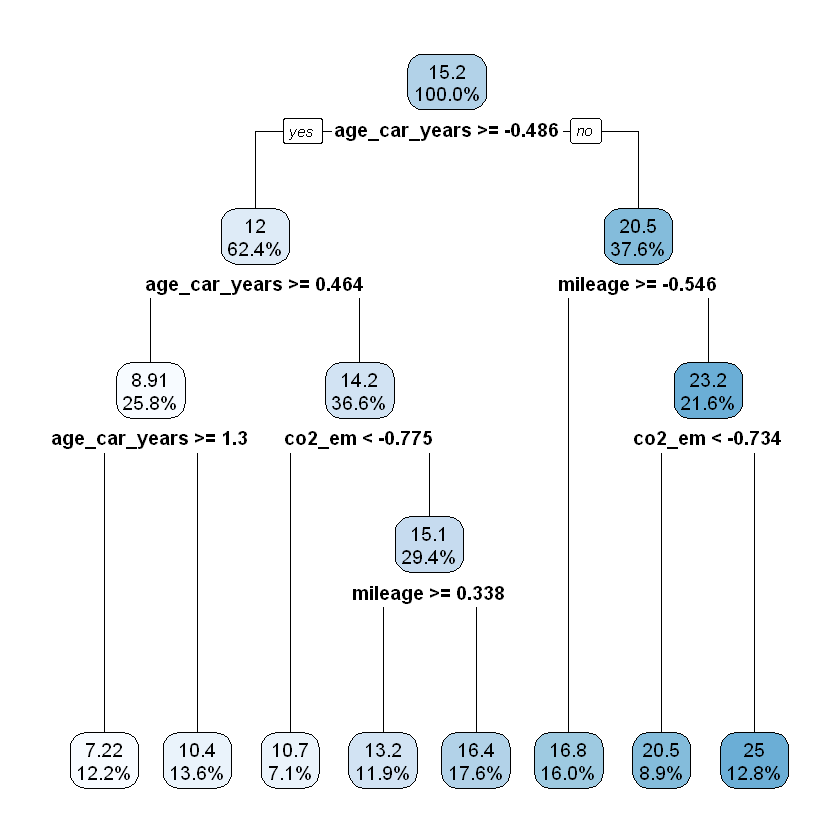

In [44]:
########################  Visulatisation of tree  ######################## 

## Plot tree structure
rpart.plot(treepruned.linearsingle_1,digits=3)

# Save tree structure as png-file
#png(filename= "full_tree1.png",units="in", width=9, height=9, pointsize=12,res=72)
#rpart.plot(treepruned.linearsingle_1,digits=3)
#dev.off()


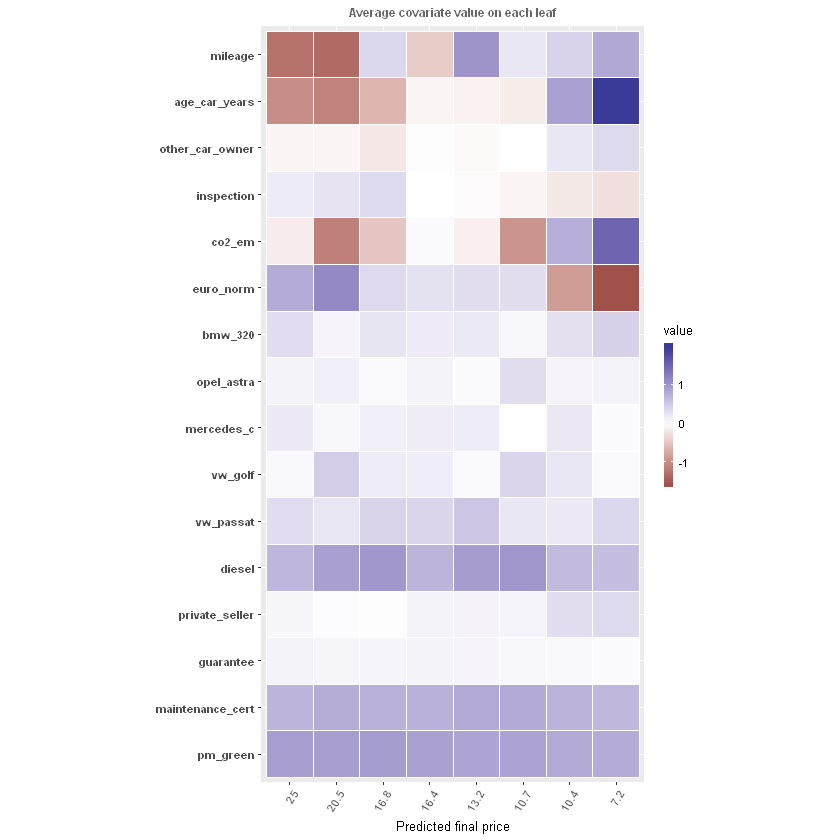

In [43]:
#####

## Plot average regresor value for each leaf
# Take hold-out data only
tree_data_out <- data.frame(pred_tree_hold_out_1, baseline_covariates_hold_out)

# Map to each individual row the leaf number and add the covariates
individual_leaf <- treeClust::rpart.predict.leaves(treepruned.linearsingle_1, tree_data_out)  %>% 
  as_tibble()  %>% 
  dplyr::rename(leaf=value) 
leaf_covariates <- cbind(individual_leaf, tree_data_out[baseline_covariates])

# Get predicted final price of each leaf 
leaf_price <- treepruned.linearsingle_1$frame %>% as_tibble() %>%
  dplyr::mutate(row = 1:nrow(.)) %>% 
  dplyr::filter(var == "<leaf>") %>% 
  dplyr::rename(leaf=row, pred_price=yval) %>% 
  dplyr::select(leaf, pred_price) 

# Merge all the information on leaf level
leaf_data <- left_join(leaf_covariates, leaf_price, by="leaf")

# Mean of each covariate on each leaf, 
# Leafs sorted and renumbered by predicted prive
leaf_mean <- leaf_data %>% 
  dplyr::group_by(leaf) %>%
  dplyr::summarise_all(mean) %>%
  dplyr::arrange(desc(pred_price)) %>%
  dplyr::mutate(leaf = 1:nrow(.)) 

# Plot
plt <- leaf_mean %>% 
  dplyr::select(leaf, baseline_covariates[c(16:1)]) %>%
  melt(id="leaf") %>%
  ggplot(aes(x=factor(leaf), y=variable, fill=value)) +
  geom_raster() +
  scale_fill_gradient2() + 
  scale_x_discrete(breaks=seq_along(leaf_mean$pred_price),      
                   labels=round(leaf_mean$pred_price, 1)) +
  # From here on, all the code is optional styling
  geom_tile(colour="white",size=0.25) +            # white cell border
  labs(x="Predicted final price",
       y="", title="Average covariate value on each leaf") +# axis labels 
  coord_fixed()+                                   # square cells
  theme_grey(base_size=8)+                         # basic hue 
  theme(
    axis.text=element_text(face="bold"),      # axis font style
    plot.background=element_blank(),          # cleaner background
    panel.border=element_blank(),             # cleaner panel
    legend.key.width=grid::unit(0.2,"cm"),    # slim legend color bar
    axis.ticks=element_line(size=0.4),        # tick style
    axis.text.x=element_text(size=7,          # tick label style
                             colour="grey40",
                             angle = 60,
                             hjust = 1),
    plot.title=element_text(colour="grey40",  # plot title style
                            hjust=.5,size=7,
                            face="bold")
  )

plot(plt)

# Save average covariate values as png-file
#png(filename= "regressor_values.png",units="in", width=6, height=6, pointsize=38,res=300)
#plt
#dev.off()